# Benchmarking image processing filters using scikit-image, scipy, simple-itk and clesperanto
Here we compare performance of a Gaussian filter implemented in [scikit-image](https://scikit-image.org), [scipy](https://scipy.org), [SimpleITK](https://simpleitk.org/) and [clEsperanto](https://github.com/clEsperanto/pyclesperanto).

**Please note:** This notebook will stress-test your graphics card. Before running it, save all files. It is possible that the graphics cards driver crashes while executing this. If you feel unsure, consider running this notebook on the cluster only.

In [1]:
import pyclesperanto as cle
# alternatively:
# import pyclesperanto_prototype as cle
from skimage.io import imread
import numpy as np
from scipy import ndimage as sndi
import stackview
from timeit import timeit
import skimage.filters
from scipy import ndimage as sndi
import napari_simpleitk_image_processing as nsitk

In [2]:
cle.available_device_names()

['gfx1103', 'NVIDIA GeForce RTX 4070 Laptop GPU']

In [3]:
# to measure kernel execution duration properly, we need to set this flag. It will slow down exection of workflows a bit though
cle.wait_for_kernel_to_finish(True)

# selet a GPU with the following in the name. This will fallback to any other GPU if none with this name is found
cle.select_device('TX')

(OpenCL) NVIDIA GeForce RTX 4070 Laptop GPU (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              560.94
	Device Type:                 GPU
	Compute Units:               36
	Global Memory Size:          8187 MB
	Local Memory Size:           0 MB
	Maximum Buffer Size:         2046 MB
	Max Clock Frequency:         1230 MHz
	Image Support:               Yes

In [4]:
image = imread('../02a_image_processing/data/Haase_MRT_tfl3d1.tif')
image.shape

(192, 256, 256)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 4 4 3]
 ...
 [0 0 0 ... 2 3 6]
 [0 0 0 ... 2 6 7]
 [0 0 0 ... 4 6 4]]
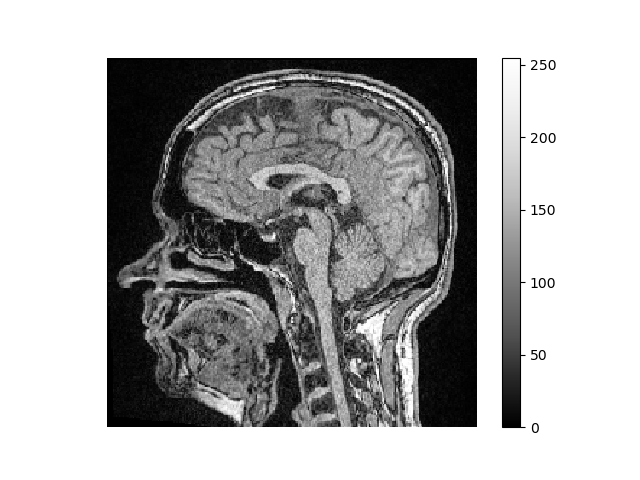
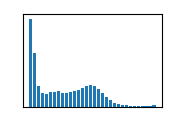

In [5]:
stackview.insight(image[96])

## scikit-image

In [6]:
blurred_image = np.zeros(image.shape)

In [7]:
%%timeit
skimage.filters.gaussian(image, sigma=5, out=blurred_image, preserve_range=True)

2.53 s ± 21.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


[[0.59139136 0.71693155 0.84692224 ... 1.55170787 1.55646128 1.5606076 ]
 [0.71218527 0.86322416 1.01958028 ... 1.87179553 1.87751562 1.88260659]
 [0.83524583 1.01217551 1.19527643 ... 2.19943104 2.20608908 2.2121322 ]
 ...
 [0.41309647 0.52557387 0.64958766 ... 3.85316926 3.78275264 3.73057484]
 [0.30459691 0.38759437 0.4791583  ... 3.88599436 3.81981216 3.77180515]
 [0.21742569 0.27671983 0.34217517 ... 3.91652227 3.85467273 3.8109427 ]]
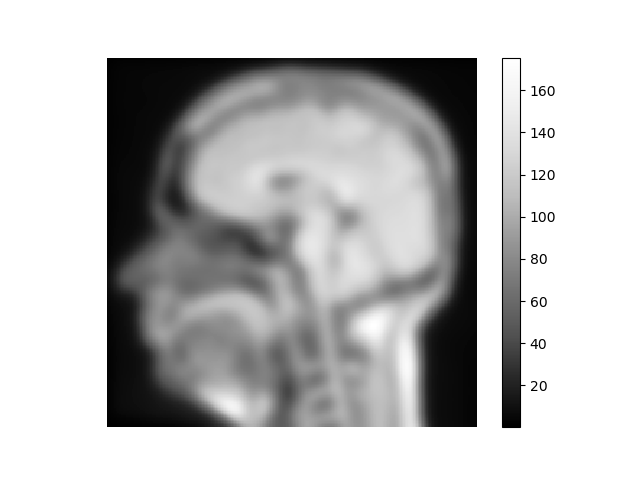
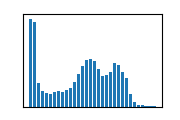

In [8]:
stackview.insight(blurred_image[96])

## scipy

In [9]:
blurred_image2 = np.zeros(image.shape)

In [10]:
%%timeit
sndi.gaussian_filter(image, sigma=(5, 5, 5), output=blurred_image2);

1.78 s ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


[[1.92665446 1.96458493 2.03673898 ... 2.80296626 2.80856044 2.81153923]
 [1.9585392  1.99702516 2.0702371  ... 2.85060195 2.8561037  2.85903662]
 [2.01876604 2.05828944 2.13347688 ... 2.94082881 2.94614162 2.94898057]
 ...
 [0.84181127 0.87677675 0.94364001 ... 3.84475017 3.78670372 3.75746603]
 [0.71331469 0.74302137 0.79985771 ... 3.85692334 3.79910538 3.76998277]
 [0.64769209 0.67471173 0.72642388 ... 3.86335026 3.80565843 3.77659959]]
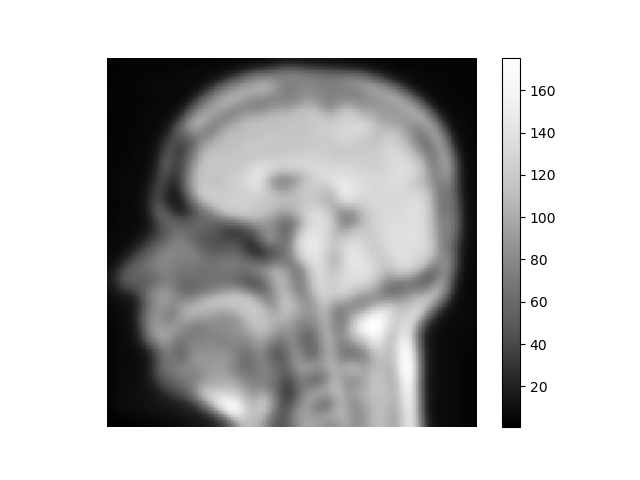
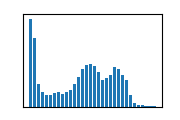

In [11]:
stackview.insight(blurred_image2[96])

## simpleitk

In [12]:
%%timeit
nsitk.gaussian_blur(image, variance_x=25, variance_y=25, variance_z=25)
# note: ITK expects the variance, which is sigma squared.

443 ms ± 11.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
blurred_image3 = nsitk.gaussian_blur(image, variance_x=25, variance_y=25, variance_z=25)

[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]]
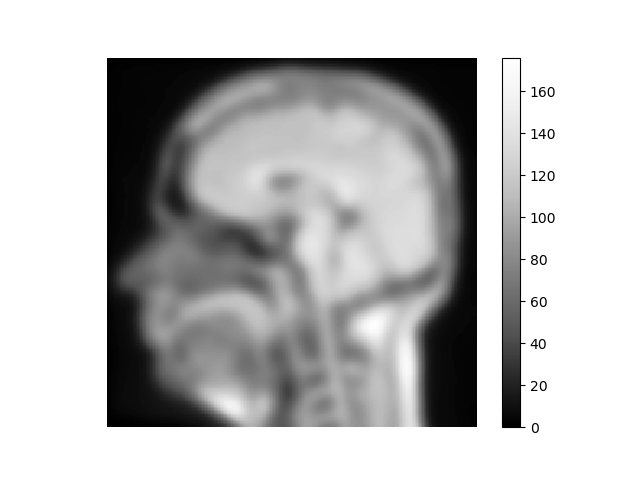
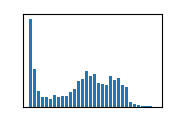

In [14]:
stackview.insight(blurred_image3[96])

## clEsperanto

In [15]:
ocl_image = cle.push(image)
ocl_blurred = cle.create(ocl_image.shape)

In [16]:
%%timeit
cle.gaussian_blur(ocl_image, output_image=ocl_blurred, sigma_x=5, sigma_y=5, sigma_z=5)

19.2 ms ± 465 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


array([[0.59139127, 0.71693146, 0.8469222 , ..., 1.5517076 , 1.5564612 ,
        1.5606073 ],
       [0.7121851 , 0.86322397, 1.01958   , ..., 1.8717952 , 1.8775152 ,
        1.8826066 ],
       [0.83524555, 1.0121754 , 1.195276  , ..., 2.199431  , 2.2060888 ,
        2.2121315 ],
       ...,
       [0.4130965 , 0.5255738 , 0.64958763, ..., 3.8531687 , 3.7827523 ,
        3.7305744 ],
       [0.30459687, 0.38759422, 0.47915825, ..., 3.8859937 , 3.8198118 ,
        3.7718053 ],
       [0.21742564, 0.27671975, 0.3421752 , ..., 3.9165215 , 3.854672  ,
        3.8109417 ]], dtype=float32, mtype=buffer)
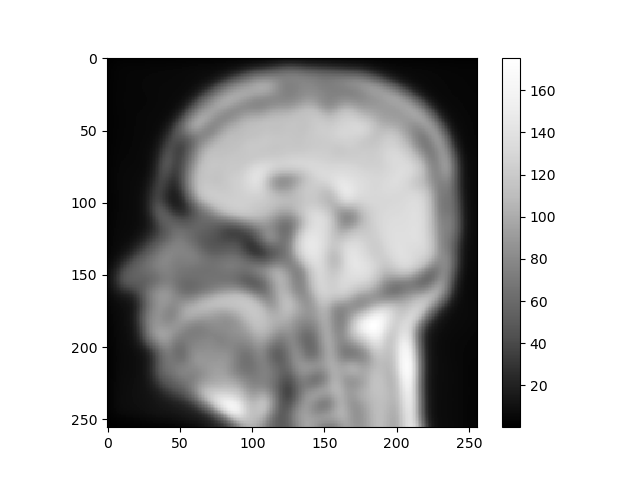
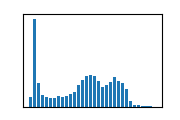

In [17]:
ocl_blurred[96]

In [18]:
del ocl_image
del ocl_blurred

## Exercise
Go back 2 weeks to the [exercise where we compared Voronoi-Otsu-Labeling in two libraries](https://github.com/ScaDS/BIDS-lecture-2025/blob/main/03a_image_segmentation/11_voronoi_otsu_labeling.ipynb). Benchmark these two functions. How much faster is the one compared to the other on your laptop? How much faster is it on the cluster?

In [19]:
from napari_segment_blobs_and_things_with_membranes import voronoi_otsu_labeling